### TRAINING AND EVALUATING PILOTNET

##### Credits

PilotNet model explained in paper: arXiv:1604.07316 

Parts of this code were taken and adapted from the following source: https://github.com/Alzaib/Autonomous-Self-Driving-Car-GTA-5

##### Imports

In [60]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg

import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, LSTM, Reshape, Input, Concatenate, ZeroPadding2D, GlobalMaxPool2D
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from imgaug import augmenters  as iaa
import cv2
import ntpath
import random
from keras.layers import Lambda,  Activation
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
import random

from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
tf.__version__

'2.10.0'

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##### DATA
The data consists of images along with corresponding throttle and steering angle values captured at the same moment as the image.
Download data: https://drive.google.com/drive/folders/1R787vkWaMe5nsWyLpbXTG55aUv4YteTo

In [4]:
#height and width of data images
WIDTH = 160
HEIGHT = 120

In [5]:
#load data
train_data1 = np.load('data/training_data-1.npy', allow_pickle=True)
train_data2 = np.load('data/training_data-2.npy', allow_pickle=True)
train_data3 = np.load('data/training_data-3.npy', allow_pickle=True)
train_data4 = np.load('data/training_data-4.npy', allow_pickle=True)
train_data5 = np.load('data/training_data-5.npy', allow_pickle=True)
train_data6 = np.load('data/training_data-6.npy', allow_pickle=True)
train_data7 = np.load('data/training_data-7.npy', allow_pickle=True)
train_data8 = np.load('data/training_data-8.npy', allow_pickle=True)
train_data9 = np.load('data/training_data-9.npy', allow_pickle=True)
train_data10 = np.load('data/training_data-10.npy', allow_pickle=True)
train_data11 = np.load('data/training_data-11.npy', allow_pickle=True)
train_data12 = np.load('data/training_data-12.npy', allow_pickle=True)
train_data13 = np.load('data/training_data-13.npy', allow_pickle=True)
train_data14 = np.load('data/training_data-14.npy', allow_pickle=True)
train_data15 = np.load('data/training_data-15.npy', allow_pickle=True)
train_data16 = np.load('data/training_data-16.npy', allow_pickle=True)
train_data17 = np.load('data/training_data-17.npy', allow_pickle=True)
train_data18 = np.load('data/training_data-18.npy', allow_pickle=True)
train_data19 = np.load('data/training_data-19.npy', allow_pickle=True)
train_data20 = np.load('data/training_data-20.npy', allow_pickle=True)
train_data21 = np.load('data/training_data-21.npy', allow_pickle=True)
train_data22 = np.load('data/training_data-22.npy', allow_pickle=True)
train_data23 = np.load('data/training_data-23.npy', allow_pickle=True)
train_data24 = np.load('data/training_data-24.npy', allow_pickle=True)
train_data25 = np.load('data/training_data-25.npy', allow_pickle=True)

train_data =  np.concatenate((train_data1, train_data2, train_data3, train_data4, train_data5, train_data6, train_data7,
                             train_data8, train_data9, train_data10, train_data11, train_data12, train_data13, train_data14,
                             train_data15, train_data16, train_data17, train_data18, train_data19, train_data20, train_data21,
                             train_data22, train_data23, train_data24, train_data25))

print ("Train Data: ", train_data.shape)

Train Data:  (100000, 2)


In [6]:
#clear the array
train_data1 = []
train_data2 = []
train_data3 = []
train_data4 = []
train_data5 = []
train_data6 = []
train_data7 = []
train_data8 = []
train_data9 = []
train_data10 = []
train_data11 = []
train_data12 = []
train_data13 = []
train_data14 = []
train_data15 = []
train_data16 = []
train_data17 = []
train_data18 = []
train_data19 = []
train_data20 = []
train_data21 = []

In [7]:
#seperate data into steering and throttle 
steering = []
throttle = []
for data in train_data:
    image = data [0]
    steering_data = data [1][0]
    throttle_data = data [1][1]
  
    choice = [steering_data, throttle]
    steering.append(steering_data)
    throttle.append(throttle_data)

steering = np.array(steering)
throttle = np.array(throttle)

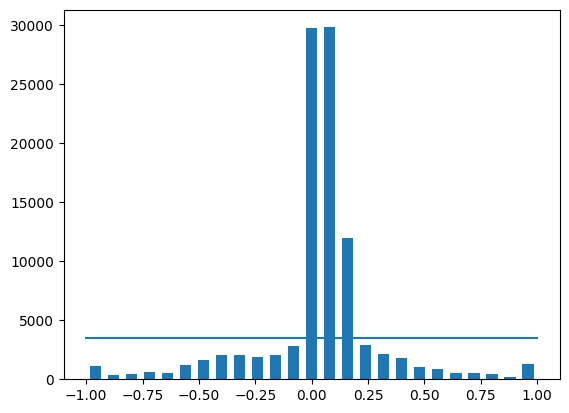

In [8]:
#plotting the steering angles in the data will show which cases are most frequent in the data
num_bins = 25
samples_per_bin = 3500
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
plt.plot((np.min(steering), np.max(steering)), (samples_per_bin, samples_per_bin))

In [9]:
#balance the steering to ensure that diverse cases and less common scenarios are equally represented in the data 
print ('total data', len(train_data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(steering)):
        if steering[i] >= bins[j] and steering[i]<=bins[j+1]:
            list_.append(i) 
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print ('removed', len(remove_list))
print (np.max(remove_list))

train_data = np.delete(train_data, remove_list, axis=0)

print ('remaining:', len (train_data))

total data 100000
removed 60954
99996
remaining: 39046


In [10]:
#seperate balanced data into steering and throttle 
steering = []
throttle = []

for data in train_data:
    image = data [0]
    steering_data = data [1][0]
    throttle_data = data [1][1]
    steering.append(steering_data)
    throttle.append(throttle_data)

steering = np.array(steering)
throttle = np.array(throttle)

<BarContainer object of 25 artists>

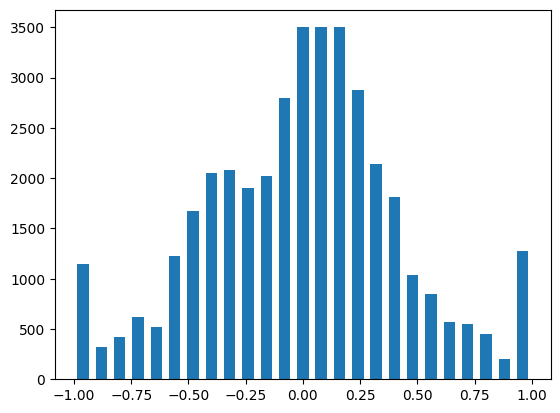

In [11]:
#Plot balanced Steering Data
num_bins = 25
samples_per_bin = 2000
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
#plt.plot((np.min(steering), np.max(steering)), (samples_per_bin, samples_per_bin))

In [12]:
def img_random_flip(image, choice):
    """
    Function to flip the image and steering angle.
    Augmentation involves generating new data with mirrored images of the original ones.
    """
    image = cv2.flip(image, 1)
    steering=choice[0]
    throttle=choice[1]
    steering = -steering
    new_choice = [steering, throttle]
    return image, new_choice

In [13]:
#Augmented data is added to dataset. This augmentation process enhances the model's learning 
#capacity by exposing it to a more diverse and varied set of examples. 
temp_train_data = []
for data in train_data:
    image = data [0]
    choice = data [1]
    flipped_image, flipped_choice = img_random_flip(image, choice)
    temp_train_data.append([flipped_image, flipped_choice])

temp_train_data =np.array(temp_train_data)
train_data = np.concatenate((train_data,temp_train_data))


print ("New Size of Training Data:", len(train_data))
train_data = shuffle(train_data)


New Size of Training Data: 78092


C:\Users\BapoBapic\AppData\Local\Temp\ipykernel_2688\625716867.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  temp_train_data =np.array(temp_train_data)


In [14]:
#seperate artificially expanded data into steering and throttle 
train_data = shuffle(train_data)
steering = []
throttle = []

for data in train_data:
    image = data [0]
    steering_data = data [1][0]
    throttle_data = data [1][1]
    steering.append(steering_data)
    throttle.append(throttle_data)

steering = np.array(steering)
throttle = np.array(throttle)

<BarContainer object of 25 artists>

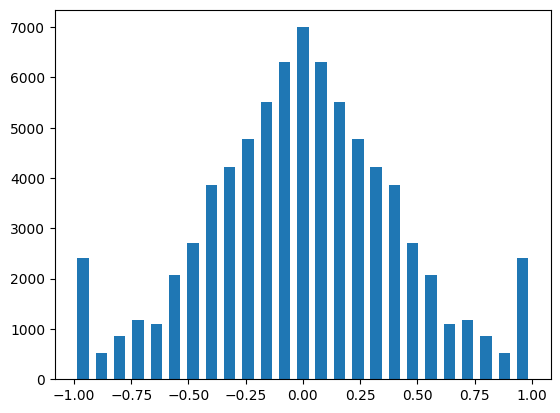

In [15]:
#Plot expanded-balanced Steering Data
num_bins = 25
samples_per_bin = 2000
hist, bins = np.histogram(steering, num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width= 0.05)
#plt.plot((np.min(steering), np.max(steering)), (samples_per_bin, samples_per_bin))

In [16]:
#Split the dataset into train and test
train = train_data[:-round(len(train_data)*0.2)] 
test = train_data[-round(len(train_data)*0.2):]
print("train: ", train.shape)
print("test: ", test.shape)

X = np.array([i[0] for i in train]).reshape(-1,WIDTH,HEIGHT,1)
Y = np.array([i[1][0] for i in train])

test_x = np.array([i[0] for i in test]).reshape(-1,WIDTH,HEIGHT,1)
test_y = np.array([i[1][0] for i in test])

train:  (62474, 2)
test:  (15618, 2)


In [17]:
def zoom(image):
    """
    Function used for augmentation that involves generating new data with zoomed images of the original ones.
    """
    zoom_img = iaa.Affine(scale = (1, 1.3))
    image = zoom_img.augment_image(image)
    return image

In [18]:
def pan(image):
    """
    Function used for augmentation that involves generating new data with panned images of the original ones.
    """
    pan = iaa.Affine(translate_percent={'x': (-0.1, 0.1), 'y': (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image
     

In [19]:
def img_random_brightness(image):
    """
    Function used for augmentation that involves generating new data with images that have changed brightness
    compared to the original ones.
    """
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

In [20]:
def img_random_flip(image, choice):
    """
    Function used for augmentation that involves generating new data with flipped images of the original ones.
    """
    image = cv2.flip(image, 1)
    new_choice = -1*choice
    return image, new_choice

In [21]:
def random_augment(image, choice):
    """
    Function used for generating new data using pan, zoom, img_random_brightness and img_random_flip functions.
    """
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, choice = img_random_flip(image, choice)
    
    return image, choice

Text(0.5, 1.0, 'Example random augmented Image')

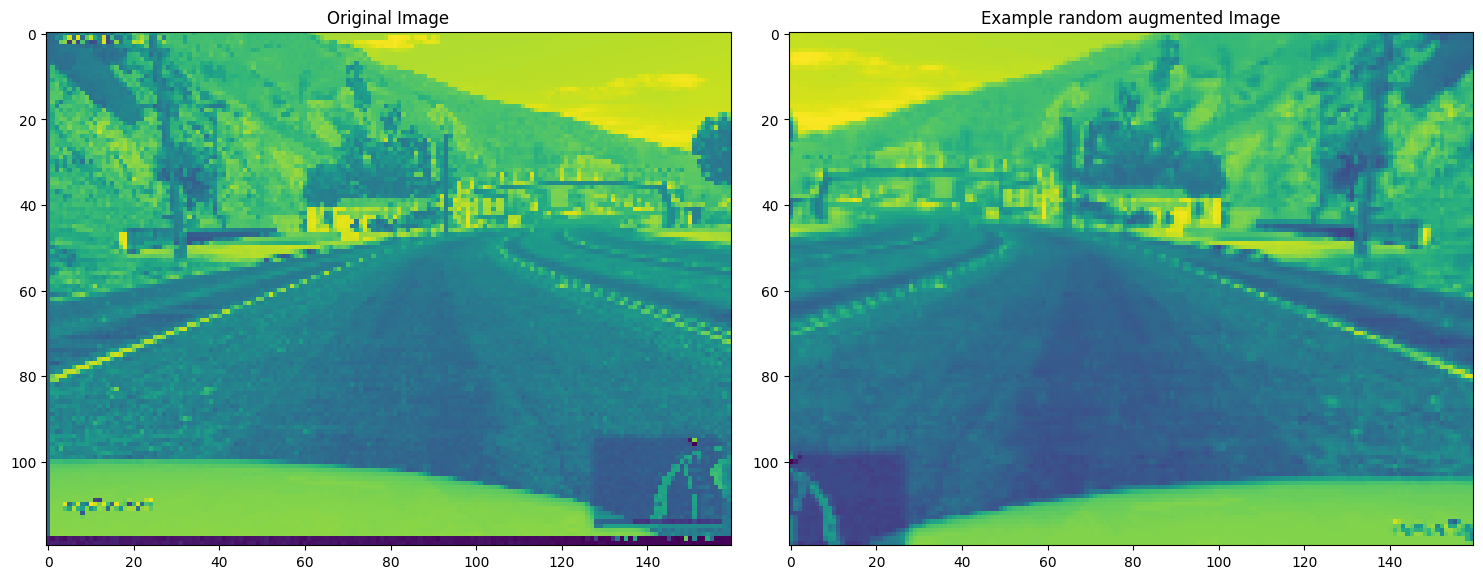

In [22]:
#example of creating new data
image, choice = train_data [random.randint(0,len(train_data)-1)]
random_augmented_image, augmented_choice = random_augment(image, choice)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(image) #cmap='gray'
axs[0].set_title('Original Image')

axs[1].imshow(random_augmented_image) #cmap='gray'
axs[1].set_title('Example random augmented Image')

#### MODEL TRAINING AND EVALUATION

In [23]:
def batch_generator(train_data_to_generate, batch_size, istraining):
    while True:
        batch_img = []
        batch_ch = []

        for i in range(batch_size):
            random_index = random.randint(0, len(train_data_to_generate)-1)
            image, choice = train_data_to_generate[random_index]
            choice = choice[0]

            if istraining:
                im, ch= random_augment(image, choice)
            else:
                im = image
                ch = choice

            im = im.reshape(WIDTH,HEIGHT,1)

            batch_img.append(im)
            batch_ch.append(ch)
        yield (np.asarray(batch_img), np.asarray(batch_ch))

In [24]:
rmse = tf.keras.metrics.RootMeanSquaredError()

In [26]:
def nvidia_model(image_x, image_y):
    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1., input_shape=(image_x, image_y, 1)))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))
    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='valid'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(1024))
    model.add(Dense(256))
    model.add(Dense(64))
    model.add(Dense(1))

    model.compile(Adam(learning_rate=0.001), loss = 'mse', metrics = ["mae", rmse])

    return model

In [27]:
model_show = nvidia_model(160,120) 
print (model_show.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 160, 120, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 120, 32)      320       
                                                                 
 activation (Activation)     (None, 160, 120, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 60, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 80, 60, 32)        0         
                                                        

In [28]:
class myCallback2(tf.keras.callbacks.Callback):

    def __init__(self):
        self.old_rmse = 1
        self.count = 0
        
    def on_epoch_end(self, epoch, logs={}):
        tmp =  logs.get('val_root_mean_squared_error')
        if( (self.old_rmse - tmp) > 0.009):
            self.old_rmse = tmp
            name = 'model_steer'+str(self.count)+'.h5'
            model_keepline.save(name)
            self.count = self.count + 1
            print(f"Model saved with {self.old_rmse} rmse, number {self.count-1}")

In [29]:
model_keepline = nvidia_model(160,120) 

with tf.device('/GPU:0'):

    history = model_keepline.fit_generator(batch_generator(train,300,1),
                                  steps_per_epoch = 100, 
                                  epochs = 5000,
                                  validation_data = batch_generator(test, 300, 0),
                                  validation_steps = 50,
                                  verbose = 1, 
                                  shuffle=1,
                                          callbacks= [myCallback2()])

C:\Users\BapoBapic\AppData\Local\Temp\ipykernel_2688\3821921910.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_keepline.fit_generator(batch_generator(train,300,1),


Epoch 1/5000
100/100 [==============================] - 68s 575ms/step - loss: 0.1896 - mae: 0.3366 - root_mean_squared_error: 0.4355 - val_loss: 0.1817 - val_mae: 0.3310 - val_root_mean_squared_error: 0.4263
Epoch 2/5000
 42/100 [===========>..................] - ETA: 34s - loss: 0.1777 - mae: 0.3248 - root_mean_squared_error: 0.4215

KeyboardInterrupt: 

In [30]:
model_keepline = tf.keras.models.load_model('pilotnet_gta5/model_steer.h5')

(120, 160)
Actual:  [-0.12078857421875, 0.999969482421875]
1/1 [==============================] - 1s 671ms/step
Prediction:  [[-0.13025315]]


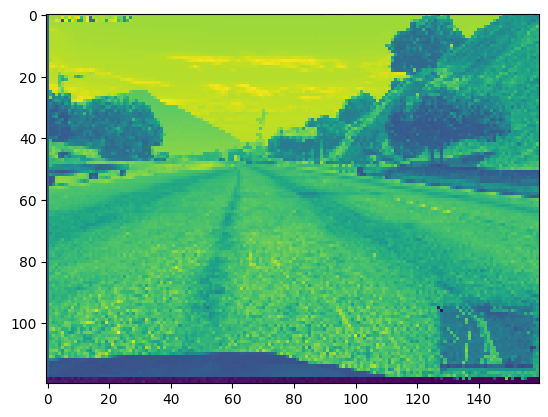

In [31]:
img_testing, choice_testing = test [random.randint(0,len(test)-1)]
print(img_testing.shape)
img_testing = img_testing.reshape(120,160)
plt.imshow(img_testing)
print ("Actual: ", choice_testing)
img_testing = img_testing.reshape(-1,160,120,1)
print ("Prediction: ", model_keepline.predict(img_testing))

In [34]:
print("Evaluate on test data")

tmp = np.zeros(shape = (1000, 160, 120, 1))

for i in range(0,1000):
    tmp[i]=(test_x[i].reshape(160,120).reshape(160,120,1))

results = model_keepline.evaluate([tmp], test_y[:1000], batch_size=1)
print("test loss, test mae, test acc, test rmse:", results)
tmp = []

Evaluate on test data
1000/1000 [==============================] - 9s 9ms/step - loss: 0.0261 - mae: 0.1215 - acc: 0.0080 - root_mean_squared_error: 0.1614
test loss, test mae, test acc, test rmse: [0.026053646579384804, 0.12149907648563385, 0.00800000037997961, 0.16141141951084137]


### THROTTLE PREDICTION

## not used in this project...

In [35]:
def batch_generator_speed(train_data_to_generate, batch_size, istraining):
    while True:
        batch_img = []
        batch_ch = []

        for i in range(batch_size):
            random_index = random.randint(0, len(train_data_to_generate)-1)
            image, choice = train_data_to_generate[random_index]
            choice = choice[1]

            if istraining:
                im, ch= random_augment(image, choice)
            else:
                im = image
                ch = choice
            im = np.repeat(im, 3, axis=-1)
            im = im.reshape(WIDTH,HEIGHT,3)

            batch_img.append(im)
            batch_ch.append(ch)
        yield (np.asarray(batch_img), np.asarray(batch_ch))

In [36]:
rmse = tf.keras.metrics.RootMeanSquaredError()

In [37]:
# import math
# from tensorflow import keras
# from tensorflow.keras import layers

# kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

# def conv3x3(x, out_planes, stride=1, name=None):
#     x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
#     return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

# def basic_block(x, planes, stride=1, downsample=None, name=None):
#     identity = x

#     out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
#     out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
#     out = layers.ReLU(name=f'{name}.relu1')(out)

#     out = conv3x3(out, planes, name=f'{name}.conv2')
#     out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

#     if downsample is not None:
#         for layer in downsample:
#             identity = layer(identity)

#     out = layers.Add(name=f'{name}.add')([identity, out])
#     out = layers.ReLU(name=f'{name}.relu2')(out)

#     return out

# def make_layer(x, planes, blocks, stride=1, name=None):
#     downsample = None
#     inplanes = x.shape[3]
#     if stride != 1 or inplanes != planes:
#         downsample = [
#             layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
#             layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
#         ]

#     x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
#     for i in range(1, blocks):
#         x = basic_block(x, planes, name=f'{name}.{i}')

#     return x

# def resnet(x, blocks_per_layer, num_classes=1000):
#     x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
#     x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
#     x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
#     x = layers.ReLU(name='relu1')(x)
#     x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
#     x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

#     x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
#     x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
#     x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
#     x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

#     x = layers.GlobalAveragePooling2D(name='avgpool')(x)
#     initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
#     x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

#     return x

# def resnet18(x, **kwargs):
#     return resnet(x, [2, 2, 2, 2], **kwargs)



In [38]:
OUTPUT_SIZE = 1
DROPOUT_PROB = 0.5

class speed_model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.base_model = ResNet50(include_top=False, weights='imagenet')
        self.dropout = layers.Dropout(DROPOUT_PROB)
        self.fc1 = layers.Dense(128, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(OUTPUT_SIZE)

    def call(self, x):
        x = self.base_model(x)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    def save_to_path(self, path):
        self.save_weights(path)

    def load_from_path(self, path):
        self.load_weights(path)



In [39]:
class myCallback(tf.keras.callbacks.Callback):

    def __init__(self):
        self.old_rmse = 1
        
    def on_epoch_end(self, epoch, logs={}):
        tmp =  logs.get('val_root_mean_squared_error')
        if( (self.old_rmse - tmp) > 0.009):
            self.old_rmse = tmp
            model_speed.save_to_path('model_speed_best_now.pth')
            print(f"Model saved with {self.old_rmse} rmse")

In [39]:
model_speed = speed_model() 
model_speed.compile(Adam(learning_rate=0.001), loss = 'mse', metrics = ["mae", "acc", rmse])

with tf.device('/GPU:0'):

    history = model_speed.fit_generator(batch_generator_speed(train,100,1),
                                  steps_per_epoch = 100, 
                                  epochs = 5000,
                                  validation_data = batch_generator_speed(test, 300, 0),
                                  validation_steps = 50,
                                  verbose = 1, 
                                  shuffle=1, callbacks= [myCallback()])

C:\Users\BapoBapic\AppData\Local\Temp\ipykernel_4764\2035465661.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model_speed.fit_generator(batch_generator_speed(train,100,1),


Epoch 1/5000
100/100 [==============================] - 53s 391ms/step - loss: 0.3857 - mae: 0.4285 - acc: 0.0016 - root_mean_squared_error: 0.6211 - val_loss: 0.2337 - val_mae: 0.3738 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.4835
Epoch 2/5000
100/100 [==============================] - 37s 375ms/step - loss: 0.2200 - mae: 0.3641 - acc: 0.0016 - root_mean_squared_error: 0.4690 - val_loss: 0.2202 - val_mae: 0.3661 - val_acc: 0.0011 - val_root_mean_squared_error: 0.4693
Epoch 3/5000
100/100 [==============================] - 37s 368ms/step - loss: 0.2210 - mae: 0.3655 - acc: 0.0021 - root_mean_squared_error: 0.4701 - val_loss: 0.2068 - val_mae: 0.3566 - val_acc: 0.0015 - val_root_mean_squared_error: 0.4547
Epoch 4/5000
100/100 [==============================] - 34s 335ms/step - loss: 0.2156 - mae: 0.3596 - acc: 0.0010 - root_mean_squared_error: 0.4643 - val_loss: 0.2092 - val_mae: 0.3538 - val_acc: 0.0012 - val_root_mean_squared_error: 0.4574
Epoch 5/5000
100/100 [==========

Epoch 29/5000
100/100 [==============================] - 34s 335ms/step - loss: 0.1532 - mae: 0.2938 - acc: 0.0013 - root_mean_squared_error: 0.3914 - val_loss: 0.1307 - val_mae: 0.2646 - val_acc: 6.0000e-04 - val_root_mean_squared_error: 0.3615
Epoch 30/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.1507 - mae: 0.2931 - acc: 0.0012 - root_mean_squared_error: 0.3882 - val_loss: 0.1739 - val_mae: 0.3205 - val_acc: 0.0013 - val_root_mean_squared_error: 0.4171
Epoch 31/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.1518 - mae: 0.2949 - acc: 0.0012 - root_mean_squared_error: 0.3896 - val_loss: 0.1434 - val_mae: 0.2908 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.3787
Epoch 32/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.1493 - mae: 0.2901 - acc: 0.0019 - root_mean_squared_error: 0.3864 - val_loss: 0.1585 - val_mae: 0.3073 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.3981
Epoch 33/5000
100/10

100/100 [==============================] - 33s 331ms/step - loss: 0.1466 - mae: 0.2865 - acc: 0.0015 - root_mean_squared_error: 0.3829 - val_loss: 0.1998 - val_mae: 0.3589 - val_acc: 0.0013 - val_root_mean_squared_error: 0.4470
Epoch 95/5000
100/100 [==============================] - 33s 332ms/step - loss: 0.1469 - mae: 0.2881 - acc: 0.0013 - root_mean_squared_error: 0.3833 - val_loss: 0.1920 - val_mae: 0.3426 - val_acc: 0.0013 - val_root_mean_squared_error: 0.4382
Epoch 96/5000
100/100 [==============================] - 33s 332ms/step - loss: 0.1489 - mae: 0.2891 - acc: 5.0000e-04 - root_mean_squared_error: 0.3858 - val_loss: 0.1657 - val_mae: 0.3028 - val_acc: 0.0014 - val_root_mean_squared_error: 0.4070
Epoch 97/5000
100/100 [==============================] - 35s 354ms/step - loss: 0.1363 - mae: 0.2762 - acc: 4.0000e-04 - root_mean_squared_error: 0.3691 - val_loss: 0.1106 - val_mae: 0.2427 - val_acc: 0.0013 - val_root_mean_squared_error: 0.3325
Epoch 98/5000
100/100 [===============

Epoch 127/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.1162 - mae: 0.2531 - acc: 0.0015 - root_mean_squared_error: 0.3409 - val_loss: 0.1867 - val_mae: 0.3388 - val_acc: 6.0000e-04 - val_root_mean_squared_error: 0.4321
Epoch 128/5000
100/100 [==============================] - 33s 335ms/step - loss: 0.1195 - mae: 0.2553 - acc: 9.0000e-04 - root_mean_squared_error: 0.3456 - val_loss: 0.1451 - val_mae: 0.2854 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.3809
Epoch 129/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.1108 - mae: 0.2468 - acc: 0.0010 - root_mean_squared_error: 0.3329 - val_loss: 0.1026 - val_mae: 0.2325 - val_acc: 0.0014 - val_root_mean_squared_error: 0.3204
Epoch 130/5000
100/100 [==============================] - 33s 330ms/step - loss: 0.1110 - mae: 0.2463 - acc: 0.0013 - root_mean_squared_error: 0.3331 - val_loss: 0.0904 - val_mae: 0.2165 - val_acc: 0.0010 - val_root_mean_squared_error: 0.3007
Epoch 131/5000
1

Epoch 191/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0699 - mae: 0.1907 - acc: 0.0013 - root_mean_squared_error: 0.2644 - val_loss: 0.0844 - val_mae: 0.2091 - val_acc: 0.0012 - val_root_mean_squared_error: 0.2904
Epoch 192/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0696 - mae: 0.1900 - acc: 0.0010 - root_mean_squared_error: 0.2639 - val_loss: 0.0673 - val_mae: 0.1826 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.2595
Epoch 193/5000
100/100 [==============================] - 33s 332ms/step - loss: 0.0717 - mae: 0.1902 - acc: 9.0000e-04 - root_mean_squared_error: 0.2677 - val_loss: 0.0978 - val_mae: 0.2303 - val_acc: 6.6667e-04 - val_root_mean_squared_error: 0.3127
Epoch 194/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0764 - mae: 0.1979 - acc: 9.0000e-04 - root_mean_squared_error: 0.2764 - val_loss: 0.0814 - val_mae: 0.2012 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.2853
Epoch 19

Epoch 224/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.0618 - mae: 0.1751 - acc: 0.0012 - root_mean_squared_error: 0.2486 - val_loss: 0.0828 - val_mae: 0.2006 - val_acc: 0.0014 - val_root_mean_squared_error: 0.2877
Epoch 225/5000
100/100 [==============================] - 33s 335ms/step - loss: 0.0558 - mae: 0.1670 - acc: 8.0000e-04 - root_mean_squared_error: 0.2362 - val_loss: 0.1082 - val_mae: 0.2360 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.3289
Epoch 226/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.0555 - mae: 0.1675 - acc: 0.0012 - root_mean_squared_error: 0.2355 - val_loss: 0.0617 - val_mae: 0.1733 - val_acc: 0.0015 - val_root_mean_squared_error: 0.2485
Epoch 227/5000
100/100 [==============================] - 33s 332ms/step - loss: 0.0586 - mae: 0.1717 - acc: 0.0014 - root_mean_squared_error: 0.2422 - val_loss: 0.1341 - val_mae: 0.2683 - val_acc: 0.0013 - val_root_mean_squared_error: 0.3662
Epoch 228/5000
100/1

100/100 [==============================] - 33s 335ms/step - loss: 0.0564 - mae: 0.1667 - acc: 0.0013 - root_mean_squared_error: 0.2375 - val_loss: 0.0728 - val_mae: 0.1921 - val_acc: 0.0014 - val_root_mean_squared_error: 0.2698
Epoch 257/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0666 - mae: 0.1815 - acc: 0.0012 - root_mean_squared_error: 0.2580 - val_loss: 0.0676 - val_mae: 0.1839 - val_acc: 0.0012 - val_root_mean_squared_error: 0.2601
Epoch 258/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.0754 - mae: 0.1951 - acc: 8.0000e-04 - root_mean_squared_error: 0.2745 - val_loss: 0.1450 - val_mae: 0.2749 - val_acc: 7.3333e-04 - val_root_mean_squared_error: 0.3807
Epoch 259/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0778 - mae: 0.1952 - acc: 9.0000e-04 - root_mean_squared_error: 0.2789 - val_loss: 0.0925 - val_mae: 0.2147 - val_acc: 6.6667e-04 - val_root_mean_squared_error: 0.3041
Epoch 260/5000
100/100 [===

Epoch 289/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.0435 - mae: 0.1456 - acc: 8.0000e-04 - root_mean_squared_error: 0.2087 - val_loss: 0.0341 - val_mae: 0.1216 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1848
Epoch 290/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0430 - mae: 0.1458 - acc: 0.0010 - root_mean_squared_error: 0.2074 - val_loss: 0.0942 - val_mae: 0.2053 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.3069
Epoch 291/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0579 - mae: 0.1661 - acc: 0.0010 - root_mean_squared_error: 0.2407 - val_loss: 0.0752 - val_mae: 0.1876 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.2742
Epoch 292/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0542 - mae: 0.1650 - acc: 0.0010 - root_mean_squared_error: 0.2329 - val_loss: 0.0614 - val_mae: 0.1722 - val_acc: 7.3333e-04 - val_root_mean_squared_error: 0.2478
Epoch 293/50

Epoch 322/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0687 - mae: 0.1835 - acc: 9.0000e-04 - root_mean_squared_error: 0.2620 - val_loss: 0.1290 - val_mae: 0.2566 - val_acc: 0.0013 - val_root_mean_squared_error: 0.3591
Epoch 323/5000
100/100 [==============================] - 32s 326ms/step - loss: 0.0605 - mae: 0.1717 - acc: 8.0000e-04 - root_mean_squared_error: 0.2459 - val_loss: 0.0778 - val_mae: 0.1935 - val_acc: 8.6667e-04 - val_root_mean_squared_error: 0.2790
Epoch 324/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.0527 - mae: 0.1610 - acc: 8.0000e-04 - root_mean_squared_error: 0.2296 - val_loss: 0.1032 - val_mae: 0.2189 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.3213
Epoch 325/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0488 - mae: 0.1540 - acc: 8.0000e-04 - root_mean_squared_error: 0.2210 - val_loss: 0.1365 - val_mae: 0.2666 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.3695


100/100 [==============================] - 33s 333ms/step - loss: 0.0777 - mae: 0.1995 - acc: 0.0013 - root_mean_squared_error: 0.2787 - val_loss: 0.0862 - val_mae: 0.2041 - val_acc: 0.0011 - val_root_mean_squared_error: 0.2936
Epoch 388/5000
100/100 [==============================] - 33s 330ms/step - loss: 0.0597 - mae: 0.1739 - acc: 5.0000e-04 - root_mean_squared_error: 0.2444 - val_loss: 0.0345 - val_mae: 0.1255 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1857
Epoch 389/5000
100/100 [==============================] - 33s 332ms/step - loss: 0.0544 - mae: 0.1669 - acc: 9.0000e-04 - root_mean_squared_error: 0.2331 - val_loss: 0.0401 - val_mae: 0.1402 - val_acc: 7.3333e-04 - val_root_mean_squared_error: 0.2002
Epoch 390/5000
100/100 [==============================] - 33s 331ms/step - loss: 0.0511 - mae: 0.1604 - acc: 0.0013 - root_mean_squared_error: 0.2260 - val_loss: 0.0654 - val_mae: 0.1780 - val_acc: 0.0012 - val_root_mean_squared_error: 0.2557
Epoch 391/5000
100/100 [=======

Epoch 420/5000
100/100 [==============================] - 34s 339ms/step - loss: 0.0324 - mae: 0.1238 - acc: 8.0000e-04 - root_mean_squared_error: 0.1799 - val_loss: 0.0252 - val_mae: 0.1024 - val_acc: 0.0015 - val_root_mean_squared_error: 0.1586
Epoch 421/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0326 - mae: 0.1266 - acc: 0.0011 - root_mean_squared_error: 0.1807 - val_loss: 0.0584 - val_mae: 0.1544 - val_acc: 0.0013 - val_root_mean_squared_error: 0.2417
Epoch 422/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0301 - mae: 0.1218 - acc: 0.0019 - root_mean_squared_error: 0.1734 - val_loss: 0.0199 - val_mae: 0.0949 - val_acc: 0.0013 - val_root_mean_squared_error: 0.1412
Epoch 423/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0313 - mae: 0.1225 - acc: 0.0010 - root_mean_squared_error: 0.1768 - val_loss: 0.0370 - val_mae: 0.1206 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1925
Epoch 424/5000
100/100 [

100/100 [==============================] - 34s 336ms/step - loss: 0.0304 - mae: 0.1188 - acc: 0.0011 - root_mean_squared_error: 0.1744 - val_loss: 0.1257 - val_mae: 0.2492 - val_acc: 0.0011 - val_root_mean_squared_error: 0.3546
Epoch 487/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0288 - mae: 0.1153 - acc: 4.0000e-04 - root_mean_squared_error: 0.1698 - val_loss: 0.0223 - val_mae: 0.0934 - val_acc: 0.0017 - val_root_mean_squared_error: 0.1492
Epoch 488/5000
100/100 [==============================] - 33s 334ms/step - loss: 0.0280 - mae: 0.1138 - acc: 4.0000e-04 - root_mean_squared_error: 0.1672 - val_loss: 0.0366 - val_mae: 0.1253 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1913
Epoch 489/5000
100/100 [==============================] - 33s 336ms/step - loss: 0.0272 - mae: 0.1123 - acc: 0.0013 - root_mean_squared_error: 0.1650 - val_loss: 0.0542 - val_mae: 0.1569 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.2329
Epoch 490/5000
100/100 [=======

Epoch 552/5000
100/100 [==============================] - 34s 341ms/step - loss: 0.0297 - mae: 0.1157 - acc: 0.0015 - root_mean_squared_error: 0.1724 - val_loss: 0.0166 - val_mae: 0.0816 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.1290
Epoch 553/5000
100/100 [==============================] - 34s 339ms/step - loss: 0.0262 - mae: 0.1097 - acc: 0.0013 - root_mean_squared_error: 0.1618 - val_loss: 0.0180 - val_mae: 0.0814 - val_acc: 4.0000e-04 - val_root_mean_squared_error: 0.1342
Epoch 554/5000
100/100 [==============================] - 34s 339ms/step - loss: 0.0288 - mae: 0.1118 - acc: 7.0000e-04 - root_mean_squared_error: 0.1696 - val_loss: 0.0234 - val_mae: 0.0959 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1529
Epoch 555/5000
100/100 [==============================] - 34s 338ms/step - loss: 0.0257 - mae: 0.1091 - acc: 8.0000e-04 - root_mean_squared_error: 0.1604 - val_loss: 0.0448 - val_mae: 0.1342 - val_acc: 0.0011 - val_root_mean_squared_error: 0.2117
Epoch 556/50

Epoch 585/5000
100/100 [==============================] - 34s 345ms/step - loss: 0.0304 - mae: 0.1146 - acc: 0.0018 - root_mean_squared_error: 0.1744 - val_loss: 0.0264 - val_mae: 0.1002 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1624
Epoch 586/5000
100/100 [==============================] - 34s 344ms/step - loss: 0.0278 - mae: 0.1118 - acc: 0.0013 - root_mean_squared_error: 0.1666 - val_loss: 0.0314 - val_mae: 0.1044 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.1773
Epoch 587/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0256 - mae: 0.1099 - acc: 0.0014 - root_mean_squared_error: 0.1601 - val_loss: 0.0213 - val_mae: 0.0887 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1459
Epoch 588/5000
100/100 [==============================] - 34s 338ms/step - loss: 0.0255 - mae: 0.1072 - acc: 9.0000e-04 - root_mean_squared_error: 0.1596 - val_loss: 0.0175 - val_mae: 0.0800 - val_acc: 7.3333e-04 - val_root_mean_squared_error: 0.1324
Epoch 589/5000
1

100/100 [==============================] - 35s 355ms/step - loss: 0.0229 - mae: 0.1029 - acc: 0.0015 - root_mean_squared_error: 0.1512 - val_loss: 0.0102 - val_mae: 0.0646 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1012
Epoch 652/5000
100/100 [==============================] - 33s 335ms/step - loss: 0.0231 - mae: 0.1013 - acc: 0.0012 - root_mean_squared_error: 0.1521 - val_loss: 0.0197 - val_mae: 0.0820 - val_acc: 6.6667e-04 - val_root_mean_squared_error: 0.1402
Epoch 653/5000
100/100 [==============================] - 34s 338ms/step - loss: 0.0243 - mae: 0.1034 - acc: 0.0019 - root_mean_squared_error: 0.1560 - val_loss: 0.0426 - val_mae: 0.1104 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.2063
Epoch 654/5000
100/100 [==============================] - 34s 339ms/step - loss: 0.0272 - mae: 0.1086 - acc: 7.0000e-04 - root_mean_squared_error: 0.1651 - val_loss: 0.0602 - val_mae: 0.1485 - val_acc: 0.0010 - val_root_mean_squared_error: 0.2453
Epoch 655/5000
100/100 [=======

Epoch 684/5000
100/100 [==============================] - 33s 335ms/step - loss: 0.0252 - mae: 0.1058 - acc: 0.0018 - root_mean_squared_error: 0.1588 - val_loss: 0.0179 - val_mae: 0.0857 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1339
Epoch 685/5000
100/100 [==============================] - 33s 335ms/step - loss: 0.0253 - mae: 0.1058 - acc: 7.0000e-04 - root_mean_squared_error: 0.1590 - val_loss: 0.0140 - val_mae: 0.0738 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.1184
Epoch 686/5000
100/100 [==============================] - 33s 335ms/step - loss: 0.0230 - mae: 0.1016 - acc: 8.0000e-04 - root_mean_squared_error: 0.1516 - val_loss: 0.0218 - val_mae: 0.0895 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.1478
Epoch 687/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0251 - mae: 0.1052 - acc: 7.0000e-04 - root_mean_squared_error: 0.1585 - val_loss: 0.0193 - val_mae: 0.0800 - val_acc: 9.3333e-04 - val_root_mean_squared_error: 0.1388
Epoc

100/100 [==============================] - 34s 341ms/step - loss: 0.0220 - mae: 0.0993 - acc: 6.0000e-04 - root_mean_squared_error: 0.1482 - val_loss: 0.0262 - val_mae: 0.0989 - val_acc: 8.6667e-04 - val_root_mean_squared_error: 0.1620
Epoch 751/5000
100/100 [==============================] - 34s 341ms/step - loss: 0.0228 - mae: 0.0998 - acc: 0.0015 - root_mean_squared_error: 0.1509 - val_loss: 0.0248 - val_mae: 0.0900 - val_acc: 8.6667e-04 - val_root_mean_squared_error: 0.1576
Epoch 752/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0227 - mae: 0.0988 - acc: 9.0000e-04 - root_mean_squared_error: 0.1508 - val_loss: 0.0201 - val_mae: 0.0811 - val_acc: 0.0013 - val_root_mean_squared_error: 0.1419
Epoch 753/5000
100/100 [==============================] - 34s 340ms/step - loss: 0.0266 - mae: 0.1058 - acc: 6.0000e-04 - root_mean_squared_error: 0.1632 - val_loss: 0.0205 - val_mae: 0.0795 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1430
Epoch 754/5000
100/100 

Epoch 816/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0198 - mae: 0.0929 - acc: 0.0013 - root_mean_squared_error: 0.1408 - val_loss: 0.0257 - val_mae: 0.0888 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1602
Epoch 817/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0194 - mae: 0.0936 - acc: 0.0011 - root_mean_squared_error: 0.1391 - val_loss: 0.0200 - val_mae: 0.0824 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1415
Epoch 818/5000
100/100 [==============================] - 33s 331ms/step - loss: 0.0222 - mae: 0.0974 - acc: 9.0000e-04 - root_mean_squared_error: 0.1489 - val_loss: 0.0411 - val_mae: 0.1141 - val_acc: 0.0011 - val_root_mean_squared_error: 0.2028
Epoch 819/5000
100/100 [==============================] - 33s 332ms/step - loss: 0.0197 - mae: 0.0932 - acc: 0.0010 - root_mean_squared_error: 0.1402 - val_loss: 0.0133 - val_mae: 0.0573 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1153
Epoch 820/5000
100/100 [

100/100 [==============================] - 33s 330ms/step - loss: 0.0211 - mae: 0.0957 - acc: 5.0000e-04 - root_mean_squared_error: 0.1454 - val_loss: 0.0140 - val_mae: 0.0719 - val_acc: 0.0011 - val_root_mean_squared_error: 0.1182
Epoch 883/5000
100/100 [==============================] - 33s 330ms/step - loss: 0.0242 - mae: 0.1004 - acc: 0.0012 - root_mean_squared_error: 0.1555 - val_loss: 0.0142 - val_mae: 0.0723 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1193
Epoch 884/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0235 - mae: 0.0987 - acc: 0.0014 - root_mean_squared_error: 0.1532 - val_loss: 0.0099 - val_mae: 0.0547 - val_acc: 0.0010 - val_root_mean_squared_error: 0.0993
Epoch 885/5000
100/100 [==============================] - 33s 329ms/step - loss: 0.0206 - mae: 0.0943 - acc: 0.0010 - root_mean_squared_error: 0.1434 - val_loss: 0.0127 - val_mae: 0.0641 - val_acc: 0.0010 - val_root_mean_squared_error: 0.1127
Epoch 886/5000
100/100 [===============

100/100 [==============================] - 33s 333ms/step - loss: 0.0246 - mae: 0.0989 - acc: 0.0014 - root_mean_squared_error: 0.1569 - val_loss: 0.0384 - val_mae: 0.1082 - val_acc: 0.0012 - val_root_mean_squared_error: 0.1961
Epoch 949/5000
100/100 [==============================] - 33s 329ms/step - loss: 0.0225 - mae: 0.0976 - acc: 0.0015 - root_mean_squared_error: 0.1501 - val_loss: 0.0196 - val_mae: 0.0677 - val_acc: 6.6667e-04 - val_root_mean_squared_error: 0.1398
Epoch 950/5000
100/100 [==============================] - 34s 337ms/step - loss: 0.0193 - mae: 0.0925 - acc: 0.0018 - root_mean_squared_error: 0.1388 - val_loss: 0.0114 - val_mae: 0.0646 - val_acc: 0.0015 - val_root_mean_squared_error: 0.1069
Epoch 951/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0192 - mae: 0.0910 - acc: 7.0000e-04 - root_mean_squared_error: 0.1386 - val_loss: 0.0142 - val_mae: 0.0651 - val_acc: 8.0000e-04 - val_root_mean_squared_error: 0.1191
Epoch 952/5000
100/100 [=======

100/100 [==============================] - 34s 336ms/step - loss: 0.0165 - mae: 0.0866 - acc: 0.0013 - root_mean_squared_error: 0.1285 - val_loss: 0.0741 - val_mae: 0.1602 - val_acc: 0.0013 - val_root_mean_squared_error: 0.2722
Epoch 1015/5000
100/100 [==============================] - 33s 333ms/step - loss: 0.0253 - mae: 0.0985 - acc: 0.0016 - root_mean_squared_error: 0.1589 - val_loss: 0.0463 - val_mae: 0.1215 - val_acc: 0.0014 - val_root_mean_squared_error: 0.2152
Epoch 1016/5000
100/100 [==============================] - 33s 332ms/step - loss: 0.0213 - mae: 0.0938 - acc: 0.0014 - root_mean_squared_error: 0.1459 - val_loss: 0.0177 - val_mae: 0.0717 - val_acc: 0.0013 - val_root_mean_squared_error: 0.1329
Epoch 1017/5000
100/100 [==============================] - 33s 335ms/step - loss: 0.0199 - mae: 0.0920 - acc: 7.0000e-04 - root_mean_squared_error: 0.1411 - val_loss: 0.0112 - val_mae: 0.0643 - val_acc: 7.3333e-04 - val_root_mean_squared_error: 0.1057
Epoch 1018/5000
100/100 [=======

KeyboardInterrupt: 

In [40]:
model_tmp = speed_model()
model_tmp.load_from_path('model_speed_best_now.pth')

(120, 160)
Actual:  -1.0
1/1 [==============================] - 0s 76ms/step
Prediction:  [[0.96869093]]


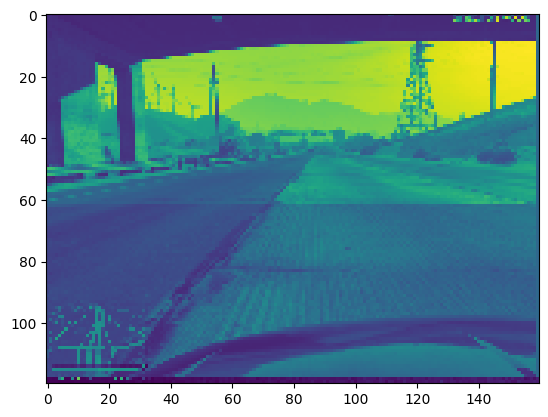

In [52]:
choice_testing = [0.0,0.0]
img_testing = None
while choice_testing[1] > -0.9:
    img_testing, choice_testing = test [random.randint(0,len(test)-1)]
print(img_testing.shape)
img = img_testing.reshape(120,160)
img = np.repeat(img, 3, axis=-1)
print ("Actual: ", choice_testing[1])

img = img.reshape(-1,160,120,3)
print ("Prediction: ", model_tmp.predict(img))

plt.imshow(img_testing)

In [54]:
model_tmp.compile(Adam(learning_rate=0.001), loss = 'mse', metrics = ["mae", "acc", rmse])
tmp = np.zeros(shape = (1000, 160, 120, 3))


for i in range(0,1000):
    im = np.repeat(test_x[i], 3, axis=-1)
    tmp[i]=(im.reshape(160,120,3))

results = model_tmp.evaluate([tmp], test_y[:1000], batch_size=1)
print("test loss, test mae, test acc, test rmse:", results)
tmp = []

1000/1000 [==============================] - 27s 24ms/step - loss: 0.3531 - mae: 0.4624 - acc: 0.0040 - root_mean_squared_error: 0.5942
test loss, test mae, test acc, test rmse: [0.35306769609451294, 0.4624042809009552, 0.004000000189989805, 0.5941951870918274]


#### FEATURE MAPS
Feature maps show road detection when processing input image

In [61]:
img = cv2.imread('snijeg-primjer.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(img.shape)

(595, 797)


['conv2d_30', 'activation_30', 'max_pooling2d_30', 'conv2d_31', 'activation_31', 'max_pooling2d_31', 'conv2d_32', 'activation_32', 'max_pooling2d_32', 'conv2d_33', 'activation_33', 'max_pooling2d_33', 'conv2d_34', 'activation_34', 'max_pooling2d_34', 'conv2d_35', 'activation_35', 'max_pooling2d_35', 'flatten_5', 'dropout_5', 'dense_20', 'dense_21', 'dense_22', 'dense_23']
1/1 [==============================] - 1s 668ms/step


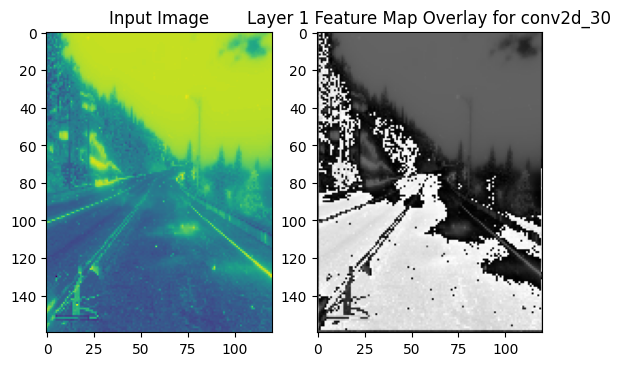

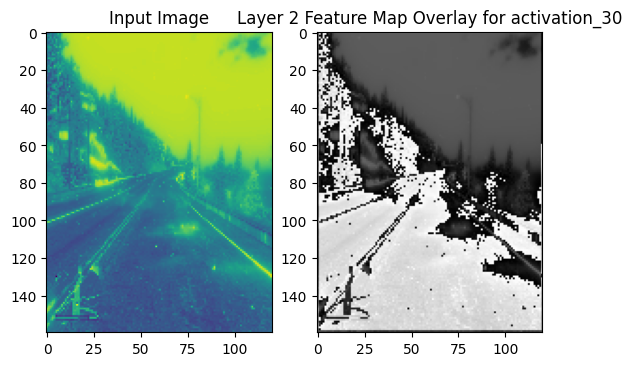

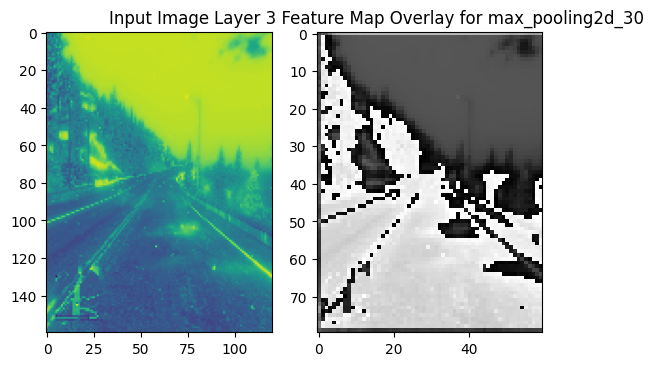

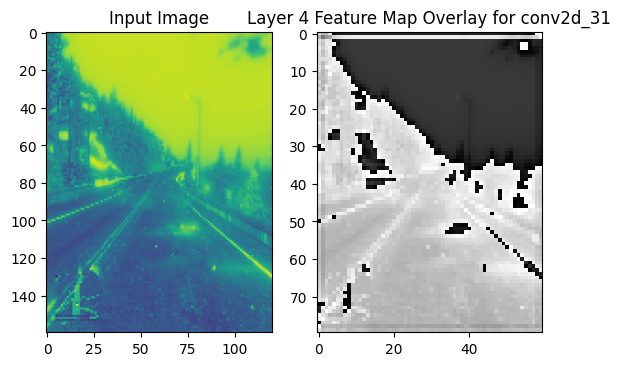

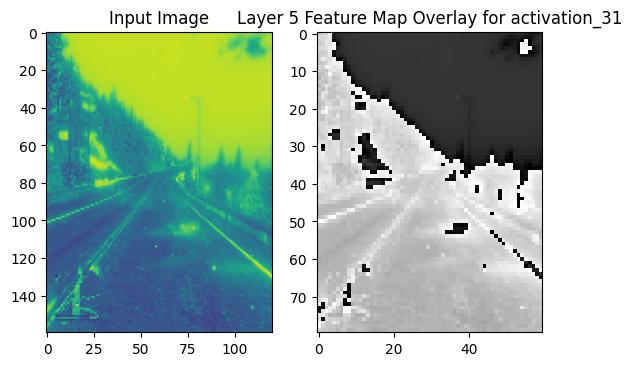

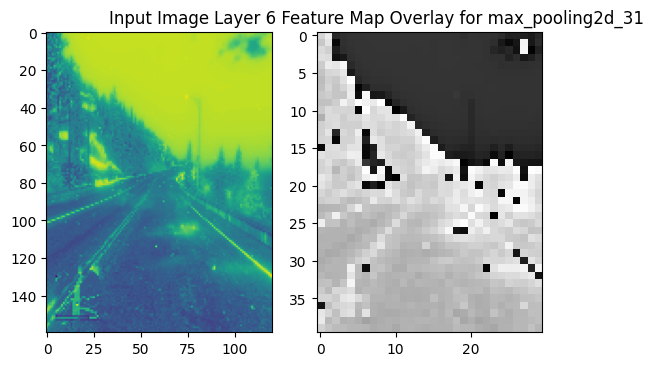

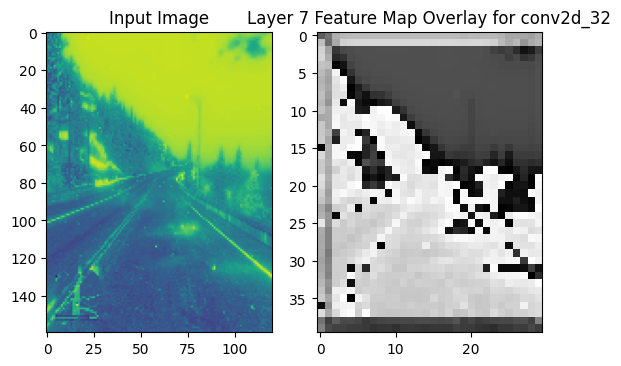

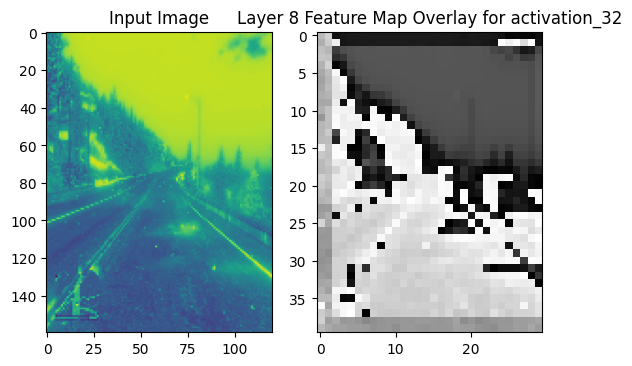

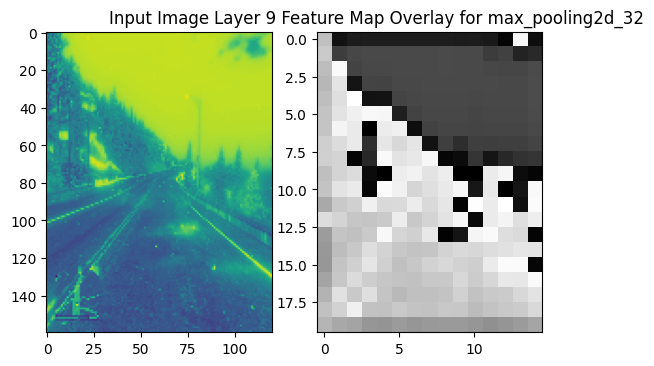

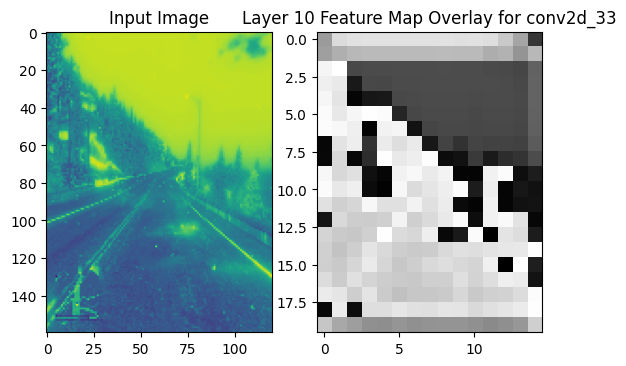

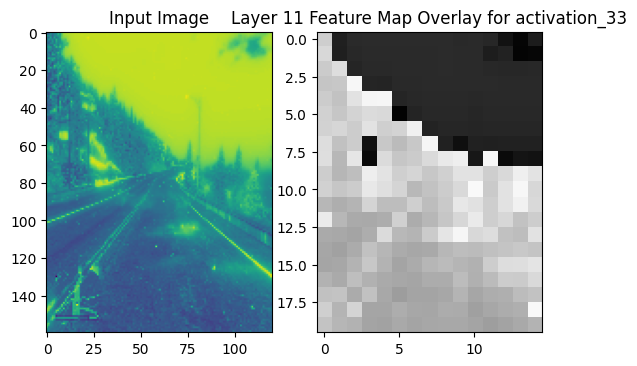

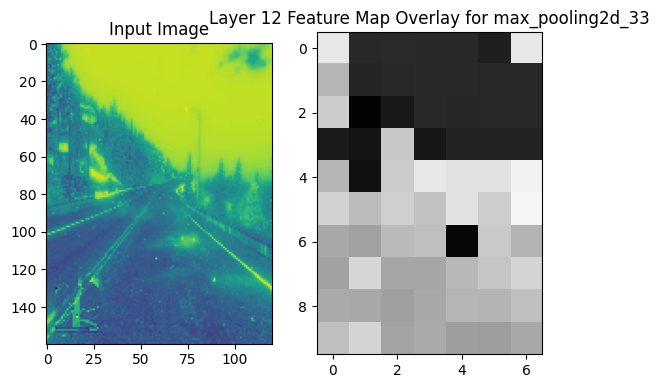

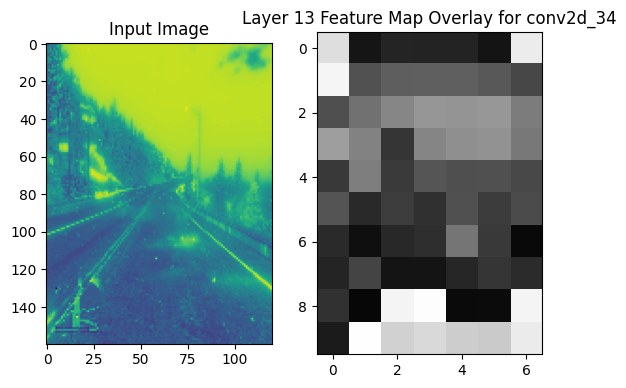

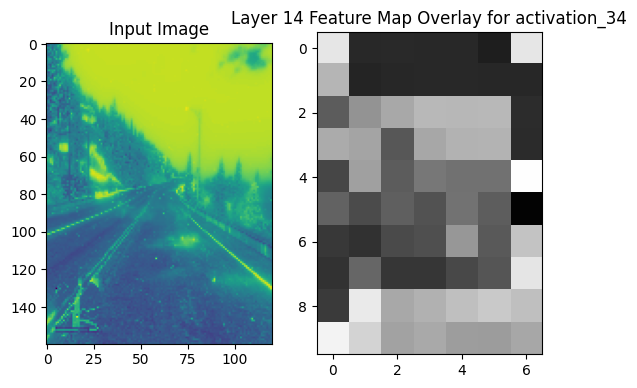

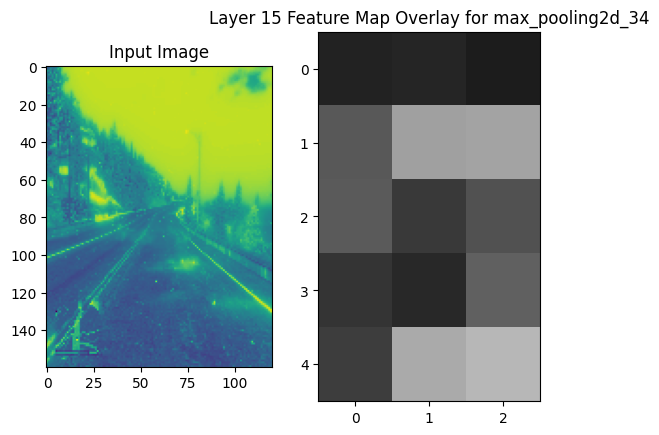

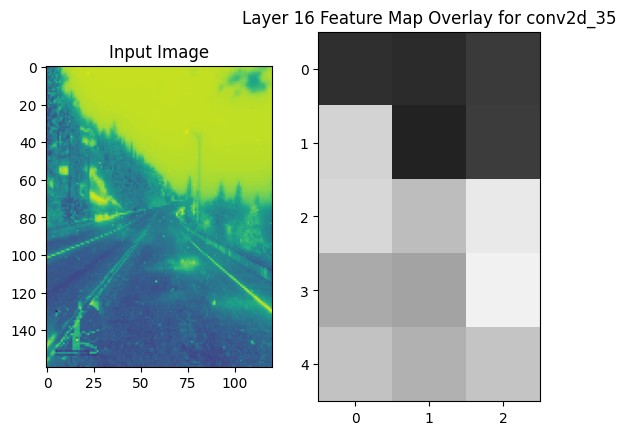

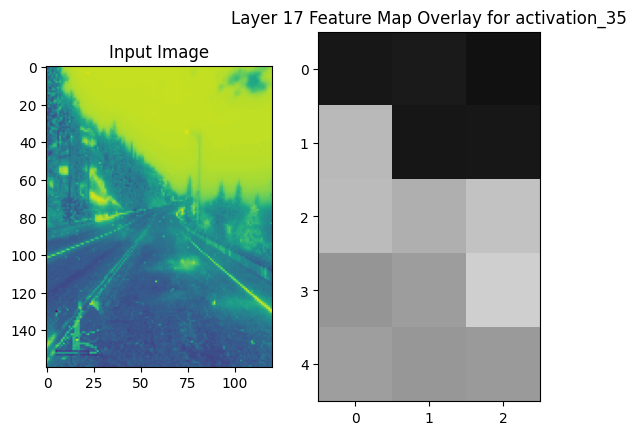

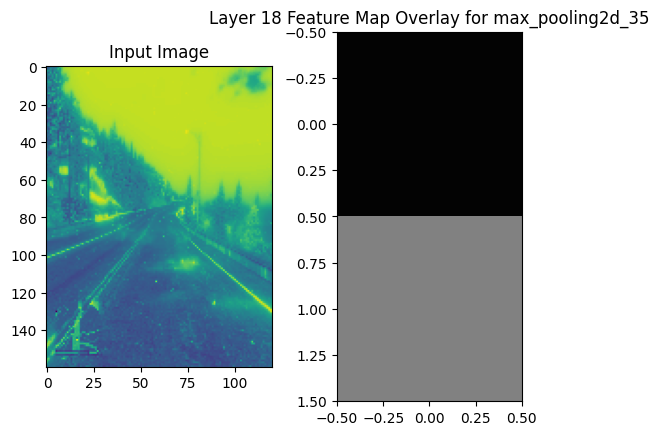

In [62]:
model = keras.models.load_model('pilotnet_gta5/model_steer.h5')
successive_outputs = [layer.output for layer in model.layers[1:]]
prints = [layer.name for layer in model.layers[1:]]
print(prints)
visualization_model = tf.keras.models.Model(inputs=model.input, outputs=successive_outputs)

image = cv2.resize(img, (120, 160))

x = img_to_array(image)  # Convert PIL image to NumPy array
x = x.reshape((1,) + x.shape)  # Reshape to match model input shape
x /= 255.0  # Rescale by 1/255

successive_feature_maps = visualization_model.predict(x)
ly = 0
for layer_index, feature_map in enumerate(successive_feature_maps):
    layer_name = prints[ly]
    # Extract the feature map for the current layer
    feature_map = feature_map[0]

    # Normalize the feature map values
    feature_map -= feature_map.mean()
    feature_map /= (feature_map.std() + 1e-8)
    feature_map *= 64
    feature_map += 128
    feature_map = np.clip(feature_map, 0, 255).astype('uint8')

    # Reshape the masked image to include the channel dimension
    masked_image = np.copy(image)
    masked_image = np.expand_dims(masked_image, axis=-1)

    # Resize the masked image to match the size of the feature map

    #print(feature_map.shape[1])
    if 'flatten' not in layer_name and 'dropout' not in layer_name and 'dense' not in layer_name:
        masked_image = tf.image.resize(masked_image, (feature_map.shape[0], feature_map.shape[1]))
        masked_image = masked_image.numpy().astype('uint8')

        # Overlay the feature map on each channel of the masked image
        for channel in range(masked_image.shape[-1]):
            masked_image[..., channel] += feature_map[..., channel]

        # Convert the masked image to TensorFlow tensor
        masked_image_tensor = tf.convert_to_tensor(masked_image)

        # Convert the overlaid image to RGB color
        masked_image_rgb = tf.image.grayscale_to_rgb(masked_image_tensor)
    
        # Display the input image and the overlaid feature map
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title('Input Image')
        plt.imshow(image)

        plt.subplot(1, 2, 2)
        plt.title(f'Layer {layer_index+1} Feature Map Overlay for {layer_name}')
        plt.imshow(masked_image_rgb.numpy().astype('uint8'))

    ly += 1

plt.show()

